In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

base_dir = 'FinalDataset'
output_dir = 'SplitDataset_Lettuce'

train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'validation')
test_dir = os.path.join(output_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for class_name in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_name)
    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        
        train_imgs, temp_imgs = train_test_split(images, test_size=(1 - train_ratio), random_state=42)
        val_imgs, test_imgs = train_test_split(temp_imgs, test_size=(test_ratio / (test_ratio + val_ratio)), random_state=42)

        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)
        
        for img_name in train_imgs:
            shutil.copy(os.path.join(class_path, img_name), os.path.join(train_dir, class_name, img_name))
        
        for img_name in val_imgs:
            shutil.copy(os.path.join(class_path, img_name), os.path.join(val_dir, class_name, img_name))
        
        for img_name in test_imgs:
            shutil.copy(os.path.join(class_path, img_name), os.path.join(test_dir, class_name, img_name))

print("Dataset successfully split into training, validation, and test sets!")


Dataset successfully split into training, validation, and test sets!


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 2047 images belonging to 3 classes.
Found 256 images belonging to 3 classes.
Found 258 images belonging to 3 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    
    Dense(128, activation='relu'),
    Dropout(0.5),
    
    Dense(len(train_generator.class_indices), activation='softmax')  
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,347 (42.61 MB)

 Trainable params: 11,169,347 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import os

def total_files(folder_path):
    return len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

Train_healthy = "SplitDataset_Lettuce/train/Healthy"
Train_bacterial = "SplitDataset_Lettuce/train/Bacterial"
Train_Fungal = "SplitDataset_Lettuce/train/Fungal"

Test_healthy = "SplitDataset_Lettuce/test/Healthy"
Test_bacterial = "SplitDataset_Lettuce/test/Bacterial"
Test_Fungal = "SplitDataset_Lettuce/test/Fungal"

Valid_healthy = "SplitDataset_Lettuce/validation/Healthy"
Valid_bacterial = "SplitDataset_Lettuce/validation/Bacterial"
Valid_Fungal = "SplitDataset_Lettuce/validation/Fungal"

print("Number of healthy leaf images in training set:", total_files(Train_healthy))
print("Number of bacterial leaf images in training set:", total_files(Train_bacterial))
print("Number of downy mildew leaf images in training set:", total_files(Train_Fungal))

print("="*90)

print("Number of healthy leaf images in test set:", total_files(Test_healthy))
print("Number of bacterial leaf images in test set:", total_files(Test_bacterial))
print("Number of downy mildew leaf images in test set:", total_files(Test_Fungal))

print("="*90)

print("Number of healthy leaf images in validation set:", total_files(Valid_healthy))
print("Number of bacterial leaf images in validation set:", total_files(Valid_bacterial))
print("Number of downy mildew leaf images in validation set:", total_files(Valid_Fungal))


Number of healthy leaf images in training set: 898
Number of bacterial leaf images in training set: 625
Number of downy mildew leaf images in training set: 524
Number of healthy leaf images in test set: 113
Number of bacterial leaf images in test set: 79
Number of downy mildew leaf images in test set: 66
Number of healthy leaf images in validation set: 112
Number of bacterial leaf images in validation set: 78
Number of downy mildew leaf images in validation set: 66


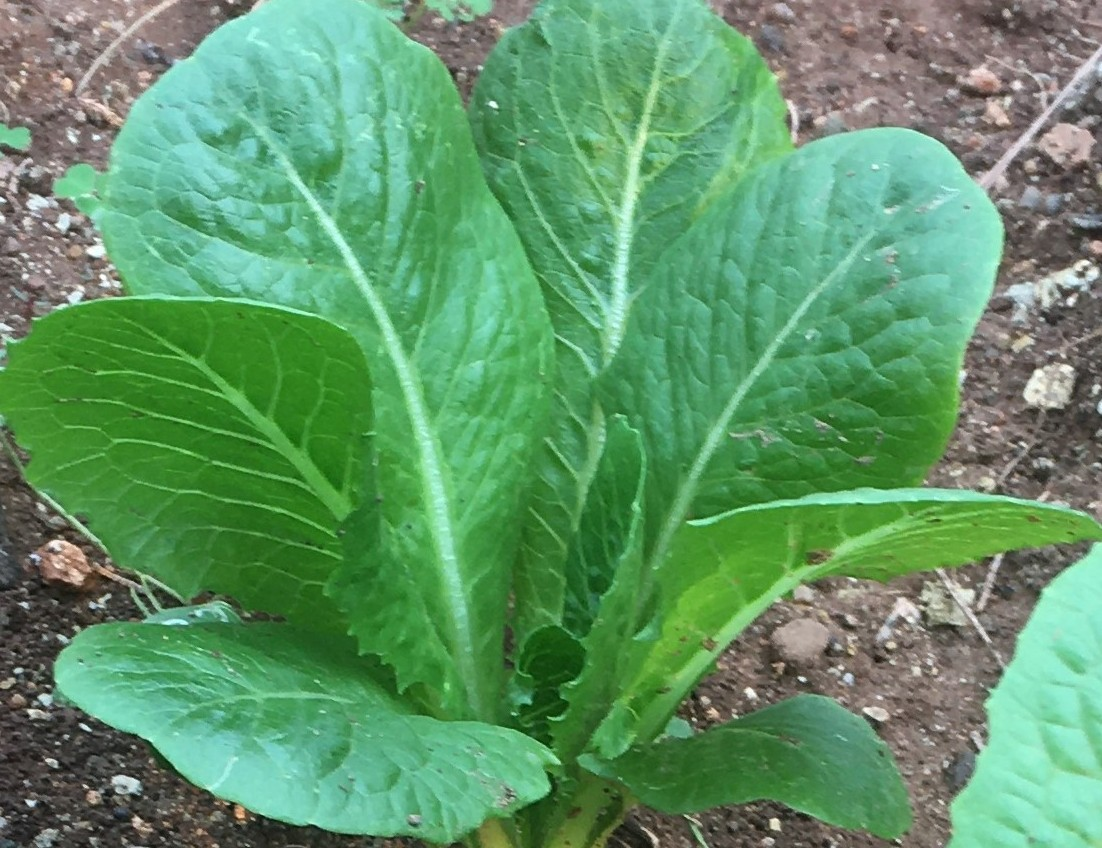

In [6]:
from PIL import Image
import IPython.display as display

image_path = "SplitDataset_Lettuce/train/Healthy/h (7).jpg"  


if os.path.exists(image_path):
    
    with open(image_path, 'rb') as f:
        display.display(display.Image(data=f.read(), width=500))
else:
    print(f"File not found: {image_path}")


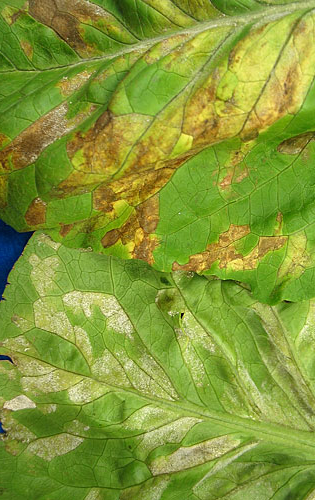

In [8]:
from PIL import Image
import IPython.display as display


image_path = "SplitDataset_Lettuce/test/Fungal/01_3.png" 

if os.path.exists(image_path):
   
    with open(image_path, 'rb') as f:
        display.display(display.Image(data=f.read(), width=500))
else:
    print(f"File not found: {image_path}")

In [9]:
height = 224
width = 224
channels = 3
num_classes = 3

In [10]:
import tensorflow as tf

def create_dataset(data, labels, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((data, labels))
    dataset = dataset.batch(batch_size)
    return dataset


In [11]:
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255.0)

train_data = data_gen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    follow_links=True 
)


Found 2047 images belonging to 3 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# I-set ang mga sukat ng imahe at batch size
image_size = (224, 224)
batch_size = 32

# Gumawa ng ImageDataGenerator para i-rescale ang pixel values ng training at validation images
train_data_gen = ImageDataGenerator(rescale=1.0 / 255.0)
valid_data_gen = ImageDataGenerator(rescale=1.0 / 255.0)

# I-load ang training images mula sa direktoryo at i-process sa generator
train_generator = train_data_gen.flow_from_directory(
    'SplitDataset_Lettuce/train',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# I-load ang validation images mula sa direktoryo at i-process sa generator
valid_generator = valid_data_gen.flow_from_directory(
    'SplitDataset_Lettuce/validation',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Gumawa ng Sequential model para sa convolutional neural network
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),  # First convolutional layer
    MaxPooling2D(pool_size=(2, 2)),  # Max pooling layer para paliitin ang feature map
    Conv2D(64, (3, 3), activation='relu'),  # Second convolutional layer
    MaxPooling2D(pool_size=(2, 2)),  # Second max pooling layer
    Flatten(),  # Flatten layer para i-transform ang 2D data sa 1D
    Dense(128, activation='relu'),  # Fully connected layer na may 128 units
    Dropout(0.5),  # Dropout layer para maiwasan ang overfitting
    Dense(train_generator.num_classes, activation='softmax')  # Output layer para sa classification
])

# I-compile ang model gamit ang Adam optimizer, categorical crossentropy na loss, at accuracy bilang metrics
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


Found 2047 images belonging to 3 classes.
Found 256 images belonging to 3 classes.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping callback para matigil ang training kapag walang improvement sa validation loss
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Itigil ang training pagkatapos ng 5 epochs na walang improvement
    verbose=1,
    restore_best_weights=True  # Ibalik ang best weights kapag natapos ang training
)

# I-train ang model gamit ang train_generator at i-validate gamit ang valid_generator
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=valid_generator,
    callbacks=[early_stopping]  # I-apply ang early stopping sa training
)


Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.5864 - loss: 2.9763 - val_accuracy: 0.7891 - val_loss: 0.4351
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.8022 - loss: 0.4112 - val_accuracy: 0.8516 - val_loss: 0.3634
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.8740 - loss: 0.3178 - val_accuracy: 0.8867 - val_loss: 0.2976
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.9114 - loss: 0.2488 - val_accuracy: 0.9062 - val_loss: 0.2408
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.9328 - loss: 0.1592 - val_accuracy: 0.9297 - val_loss: 0.2321
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.9624 - loss: 0.1016 - val_accuracy: 0.9375 - val_loss: 0.1932
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.9680 - loss: 0.0965 - val_accuracy: 0.9414 - val_loss: 0.1932
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9822 - loss: 0.0611 - val_accuracy: 0.9180 - v

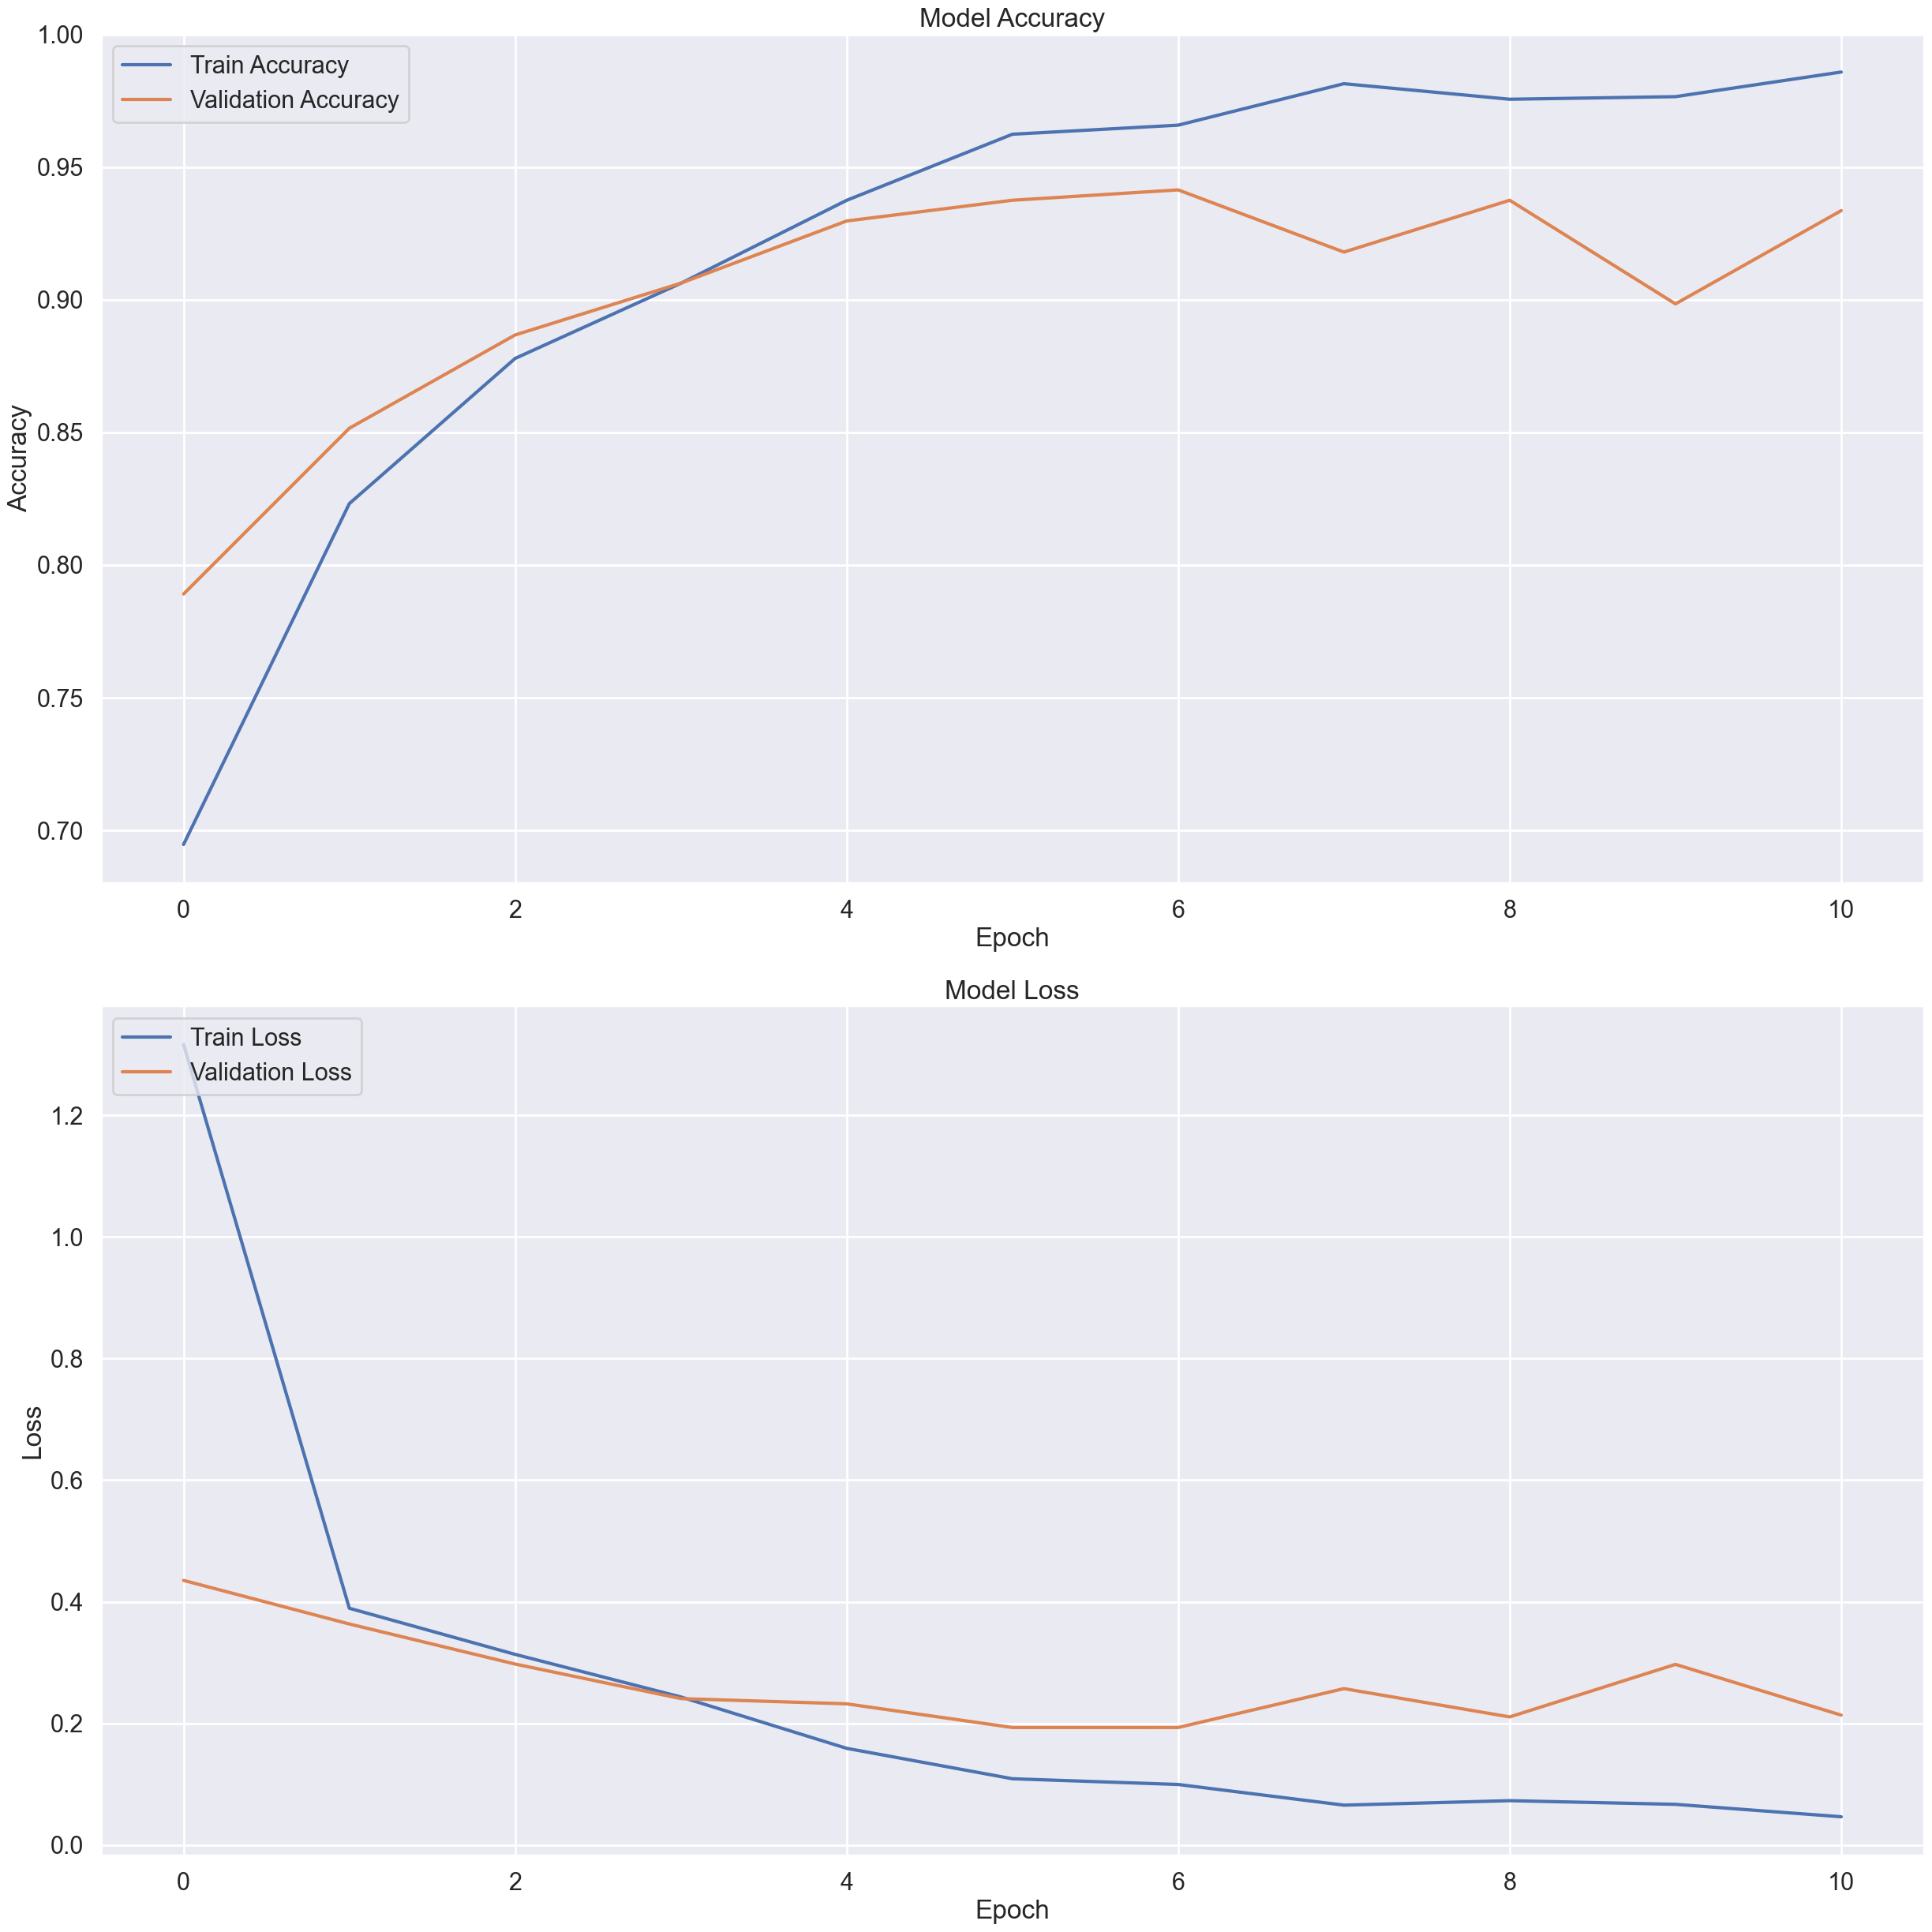

In [15]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns


sns.set_theme()
sns.set_context("poster")


figure(figsize=(25, 25), dpi=100)

# Plot training and validation accuracy
plt.subplot(2, 1, 1)  
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training and validation loss
plt.subplot(2, 1, 2)  
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')


plt.tight_layout()
plt.show()


In [17]:
model.save("LettuceModel.h5")

In [30]:
pip install matplotlib scikit-learn seaborn

Found 258 images belonging to 3 classes.
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step 
Classification Report:
              precision    recall  f1-score   support

   Bacterial       0.85      0.92      0.88        79
      Fungal       0.83      0.83      0.83        66
     Healthy       1.00      0.94      0.97       113

    accuracy                           0.91       258
   macro avg       0.89      0.90      0.90       258
weighted avg       0.91      0.91      0.91       258



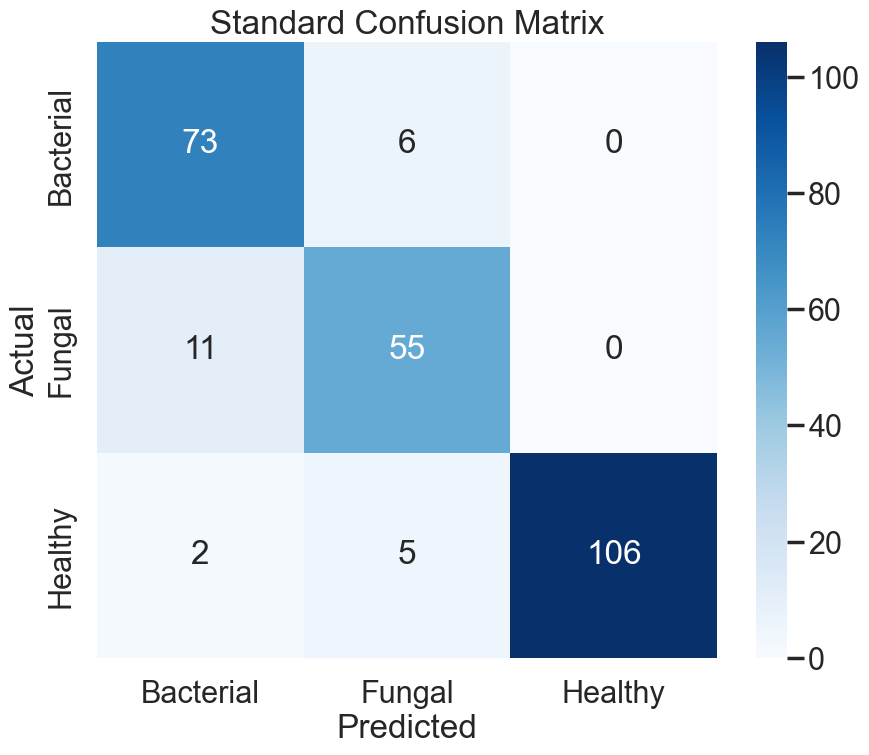

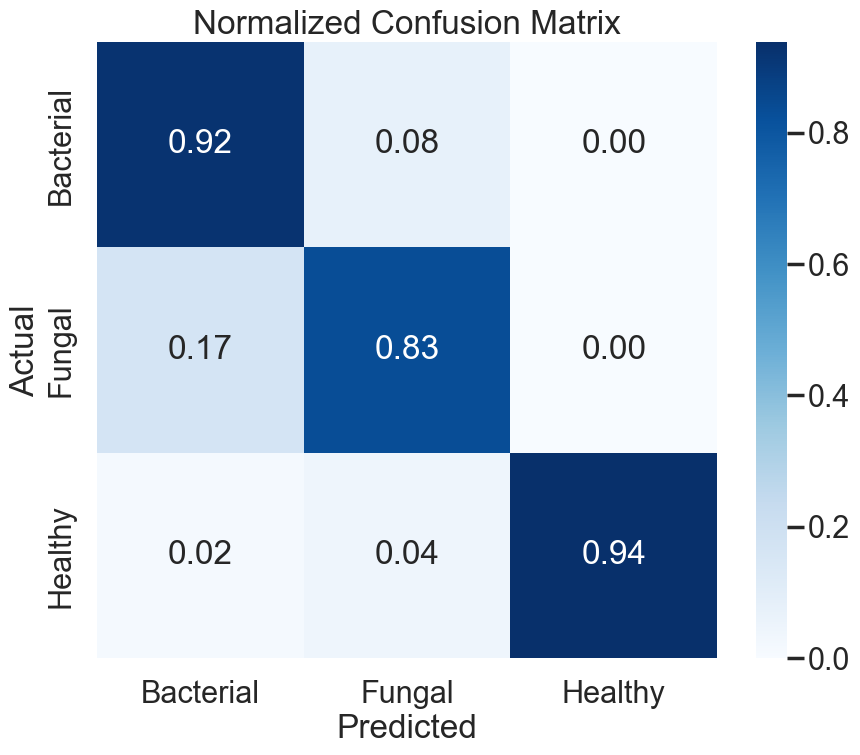

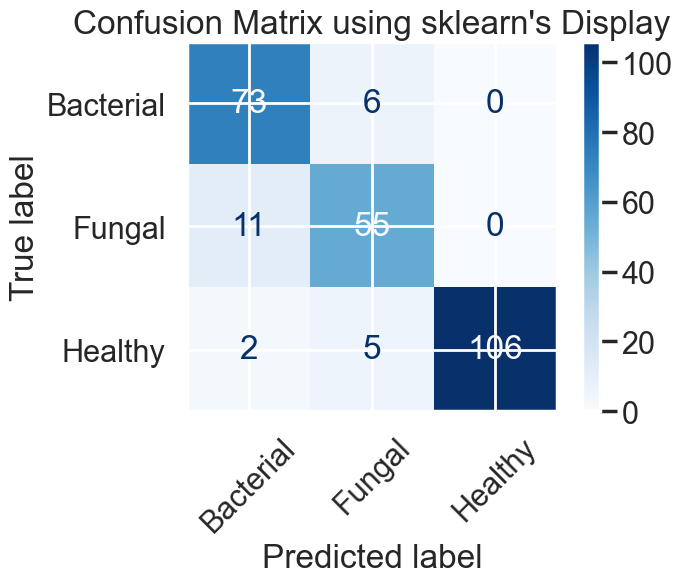

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load your trained model
from tensorflow.keras.models import load_model
model = load_model('LettuceModel.h5')

# Image dimensions and batch size
image_size = (224, 224)
batch_size = 32

# Load test data using ImageDataGenerator
test_data_gen = ImageDataGenerator(rescale=1.0 / 255.0)
test_generator = test_data_gen.flow_from_directory(
    'SplitDataset_Lettuce/test',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Predict on the test data
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, labels, title='Confusion Matrix', normalize=False):
    cm = confusion_matrix(y_true, y_pred, normalize='true' if normalize else None)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Plot Standard Confusion Matrix
plot_confusion_matrix(y_true, y_pred, class_labels, title='Standard Confusion Matrix')

# Plot Normalized Confusion Matrix
plot_confusion_matrix(y_true, y_pred, class_labels, title='Normalized Confusion Matrix', normalize=True)

# sklearn's ConfusionMatrixDisplay (alternative visualization)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix using sklearn's Display")
plt.show()


In [21]:
from sklearn.metrics import classification_report
import numpy as np
from tensorflow.keras.models import load_model


model = load_model("LettuceModel.h5")

true_labels = validation_generator.classes  
predicted_labels = model.predict(validation_generator, verbose=1)  

predicted_labels = np.argmax(predicted_labels, axis=1)

class_labels = list(validation_generator.class_indices.keys())


report = classification_report(true_labels, predicted_labels, target_names=class_labels)

print(report)


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 820ms/step
              precision    recall  f1-score   support

   Bacterial       0.24      0.27      0.26        78
      Fungal       0.25      0.21      0.23        66
     Healthy       0.42      0.42      0.42       112

    accuracy                           0.32       256
   macro avg       0.30      0.30      0.30       256
weighted avg       0.32      0.32      0.32       256



In [22]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img


model = load_model('LettuceModel.h5')

# Class labels with corresponding solutions
class_labels = {
    0: 'Bacterial',
    1: 'Fungal',
    2: 'Healthy',
}


disease_solutions = {
    0: "Apply copper-based fungicides and improve air circulation around the plants.",
    1: "Use fungicides containing metalaxyl or fosetyl-aluminum, and ensure good air circulation.",
    2: "No action needed; the plant is healthy.",
}


def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

image_path = 'SplitDataset_Lettuce/test/Healthy/h (5).jpg'
processed_image = preprocess_image(image_path)


predictions = model.predict(processed_image)[0]  

predicted_class_index = np.argmax(predictions)
predicted_class_label = class_labels.get(predicted_class_index, "Unknown")
probability = predictions[predicted_class_index] * 100


solution = disease_solutions.get(predicted_class_index, "No solution available.")

print(f"Predicted Class: {predicted_class_label}")
print(f"Probability: {probability:.2f}%")
print(f"Recommended Solution: {solution}")


if probability < 70:
    
    second_best_index = np.argsort(predictions)[-2]
    second_best_label = class_labels.get(second_best_index, "Unknown")
    second_best_prob = predictions[second_best_index] * 100
    second_best_solution = disease_solutions.get(second_best_index, "No solution available.")

    
    print("\n** Note: The image may be blurry or unclear, leading to a lower confidence level. **")
    print("Alternative Prediction:")
    print(f"Predicted Class: {second_best_label}")
    print(f"Probability: {second_best_prob:.2f}%")
    print(f"Suggested Solution: {second_best_solution}")

print("\nClass Probabilities:")
for idx, prob in enumerate(predictions):
    label = class_labels.get(idx, "Unknown")
    print(f"{label}: {prob * 100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Predicted Class: Healthy
Probability: 100.00%
Recommended Solution: No action needed; the plant is healthy.

Class Probabilities:
Bacterial: 0.00%
Fungal: 0.00%
Healthy: 100.00%


In [24]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img


model = load_model('LettuceModel.h5')

# Class labels with corresponding solutions
class_labels = {
    0: 'Bacterial',
    1: 'Fungal',
    2: 'Healthy',
}


disease_solutions = {
    0: "Apply copper-based fungicides and improve air circulation around the plants.",
    1: "Use fungicides containing metalaxyl or fosetyl-aluminum, and ensure good air circulation.",
    2: "No action needed; the plant is healthy.",
}


def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

image_path = 'SplitDataset_Lettuce/test/Bacterial/ba6_2.png'
processed_image = preprocess_image(image_path)


predictions = model.predict(processed_image)[0]  

predicted_class_index = np.argmax(predictions)
predicted_class_label = class_labels.get(predicted_class_index, "Unknown")
probability = predictions[predicted_class_index] * 100


solution = disease_solutions.get(predicted_class_index, "No solution available.")

print(f"Predicted Class: {predicted_class_label}")
print(f"Probability: {probability:.2f}%")
print(f"Recommended Solution: {solution}")


if probability < 70:
    
    second_best_index = np.argsort(predictions)[-2]
    second_best_label = class_labels.get(second_best_index, "Unknown")
    second_best_prob = predictions[second_best_index] * 100
    second_best_solution = disease_solutions.get(second_best_index, "No solution available.")

    
    print("\n** Note: The image may be blurry or unclear, leading to a lower confidence level. **")
    print("Alternative Prediction:")
    print(f"Predicted Class: {second_best_label}")
    print(f"Probability: {second_best_prob:.2f}%")
    print(f"Suggested Solution: {second_best_solution}")

print("\nClass Probabilities:")
for idx, prob in enumerate(predictions):
    label = class_labels.get(idx, "Unknown")
    print(f"{label}: {prob * 100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
Predicted Class: Bacterial
Probability: 99.31%
Recommended Solution: Apply copper-based fungicides and improve air circulation around the plants.

Class Probabilities:
Bacterial: 99.31%
Fungal: 0.69%
Healthy: 0.00%


In [29]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img


model = load_model('LettuceModel.h5')

# Class labels with corresponding solutions
class_labels = {
    0: 'Bacterial',
    1: 'Fungal',
    2: 'Healthy',
}


disease_solutions = {
    0: "Apply copper-based fungicides and improve air circulation around the plants.",
    1: "Use fungicides containing metalaxyl or fosetyl-aluminum, and ensure good air circulation.",
    2: "No action needed; the plant is healthy.",
}


def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

image_path = 'SplitDataset_Lettuce/test/Fungal/09_4.png'
processed_image = preprocess_image(image_path)


predictions = model.predict(processed_image)[0]  

predicted_class_index = np.argmax(predictions)
predicted_class_label = class_labels.get(predicted_class_index, "Unknown")
probability = predictions[predicted_class_index] * 100


solution = disease_solutions.get(predicted_class_index, "No solution available.")

print(f"Predicted Class: {predicted_class_label}")
print(f"Probability: {probability:.2f}%")
print(f"Recommended Solution: {solution}")


if probability < 70:
    
    second_best_index = np.argsort(predictions)[-2]
    second_best_label = class_labels.get(second_best_index, "Unknown")
    second_best_prob = predictions[second_best_index] * 100
    second_best_solution = disease_solutions.get(second_best_index, "No solution available.")

    
    print("\n** Note: The image may be blurry or unclear, leading to a lower confidence level. **")
    print("Alternative Prediction:")
    print(f"Predicted Class: {second_best_label}")
    print(f"Probability: {second_best_prob:.2f}%")
    print(f"Suggested Solution: {second_best_solution}")

print("\nClass Probabilities:")
for idx, prob in enumerate(predictions):
    label = class_labels.get(idx, "Unknown")
    print(f"{label}: {prob * 100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
Predicted Class: Fungal
Probability: 99.81%
Recommended Solution: Use fungicides containing metalaxyl or fosetyl-aluminum, and ensure good air circulation.

Class Probabilities:
Bacterial: 0.19%
Fungal: 99.81%
Healthy: 0.00%


In [28]:
from tensorflow.keras.models import load_model

model = load_model("LettuceModel.h5")

loss, accuracy = model.evaluate(validation_generator)

print(f"Model accuracy: {accuracy * 100:.2f}%")


8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9388 - loss: 0.1717
Model accuracy: 93.75%


In [2]:
pip install opencv-python-headless

Note: you may need to restart the kernel to use updated packages.


In [5]:
import cv2

output_path = 'frame_output.png'
cv2.imwrite(output_path, frame)


True

In [16]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt

# Load the trained model
model = load_model('LettuceModel.h5')

# Class labels with corresponding solutions
class_labels = {
    0: 'Bacterial',
    1: 'Fungal',
    2: 'Healthy',
}

disease_solutions = {
    0: "Apply copper-based fungicides and improve air circulation around the plants.",
    1: "Use fungicides containing metalaxyl or fosetyl-aluminum, and ensure good air circulation.",
    2: "No action needed; the plant is healthy.",
}

# Function to preprocess frames from the camera for prediction
def preprocess_frame(frame, target_size=(224, 224)):
    img = cv2.resize(frame, target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

# Initialize the camera
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not open camera.")
    exit()

print("Press 'q' to exit the camera feed.")

# Set up a figure for displaying the frames
plt.ion()  # Enable interactive mode
fig, ax = plt.subplots()
img_plot = ax.imshow(np.zeros((224, 224, 3), dtype=np.uint8))  # Dummy image for initialization
ax.axis('off')

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess the frame and get predictions
    processed_frame = preprocess_frame(frame)
    predictions = model.predict(processed_frame)[0]
    predicted_class_index = np.argmax(predictions)
    predicted_class_label = class_labels.get(predicted_class_index, "Unknown")
    probability = predictions[predicted_class_index] * 100
    solution = disease_solutions.get(predicted_class_index, "No solution available.")

    # Display the prediction, probability, and solution on the frame
    cv2.putText(frame, f"Class: {predicted_class_label}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    cv2.putText(frame, f"Probability: {probability:.2f}%", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    cv2.putText(frame, f"Solution: {solution}", (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    # If the prediction confidence is low, suggest an alternative prediction
    if probability < 70:
        second_best_index = np.argsort(predictions)[-2]
        second_best_label = class_labels.get(second_best_index, "Unknown")
        second_best_prob = predictions[second_best_index] * 100
        second_best_solution = disease_solutions.get(second_best_index, "No solution available.")

        # Display alternative prediction on the frame
        cv2.putText(frame, f"Alt Class: {second_best_label}", (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
        cv2.putText(frame, f"Alt Probability: {second_best_prob:.2f}%", (10, 150), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
        cv2.putText(frame, f"Alt Solution: {second_best_solution}", (10, 180), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

    # Update the figure with the new frame
    img_plot.set_data(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.draw()

    # Pause briefly to allow the figure to update
    plt.pause(0.1)

    # Press 'q' to quit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the camera and close the window
cap.release()
plt.ioff()  # Disable interactive mode
plt.close(fig)


Press 'q' to exit the camera feed.
